In [1]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    create_trajectory,
    create_trajectory_3D
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors
import matplotlib.pyplot as plt
def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break
        
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos
#######
    def move_to_absolute_x_y_z(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} Z{P[3]} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180, P[3]]  #z im Bereich 50 bis 100 mm
        return pos
###### 
    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [2]:
def generate_exp_data_3D(traj, r_path, r_anomaly, material):
    num_points = 3000
    #ref_radius = 0.2
    #scale_factor = r_path / ref_radius
    #scaled_points = int(round(base_points * scale_factor))
    #print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    # Create figure with specific size
    
    fig = plt.figure(figsize=(20, 8))
    
    center_pos = create_trajectory_3D(traj, r_path*97, num_points)
    print(center_pos)
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax1.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax1.view_init(elev=90, azim=0)  # Top view
    ax1.set_title('Top View')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax2.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax2.view_init(elev=0, azim=0)  # Side view
    ax2.set_title('Side View')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax3.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax3.view_init(elev=45, azim=45)  # Isometric view
    ax3.set_title('Isometric View')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    plt.tight_layout()
    for ax in [ax1, ax2, ax3]:
        ax.legend()
    
    plt.show()

#    base_dataset_folder = "exp_data_set_3D"
#    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
#    base_name = "exp_data_3D"
#    counter = 1
#    folder_name = os.path.join(base_dataset_folder, base_name)
#    while os.path.exists(folder_name):
#        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
#        counter += 1
#    os.makedirs(folder_name)
    
    # Logge die Parameter
#    lookup = {
#        "folder": folder_name,
#        "Trajectory": traj,
#        "Nsteps": scaled_points,
#        "r_anomaly": r_anomaly,
#        "r_path": r_path,
#        "material": material,
#    }

#    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
#    with open(lookup_file_path, 'a') as f:
#        for key, value in lookup.items():
#            f.write(f"{key}: {value}\n")
#        f.write("-" * 40 + "\n")

    # Speichere die leeren Tankmessungen als ersten Datensatz
#    file_path = os.path.join(folder_name, "sample_000000.npz")
#    empty_tank_pos = [180, 180, 50]
#    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
#             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
#    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
#        pos = printer.move_to_absolute_x_y_z(Ps)  
#        temp = printer.read_temperature()  
#        machine_time, timestamp = printer.get_timestamp()  
#        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
#        # Speichere die Messung (Start bei sample_000001.npz)
#        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
#        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
#                 temperature=temp, v=data)

#    print("Measurement is complete!")

def empty_tank_measure():
    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

[[ 1.40655570e-02 -8.50837926e-01  5.00465023e+01]
 [ 1.40655570e-02 -5.72202471e-01  5.00306608e+01]
 [ 5.14674654e-02 -2.96174759e-01  5.00177130e+01]
 ...
 [-8.69038145e-01 -8.33100504e+00  7.64769225e+01]
 [-1.78480863e+00 -8.27025991e+00  7.57248191e+01]
 [-2.60084810e+00 -8.20673987e+00  7.50288201e+01]]


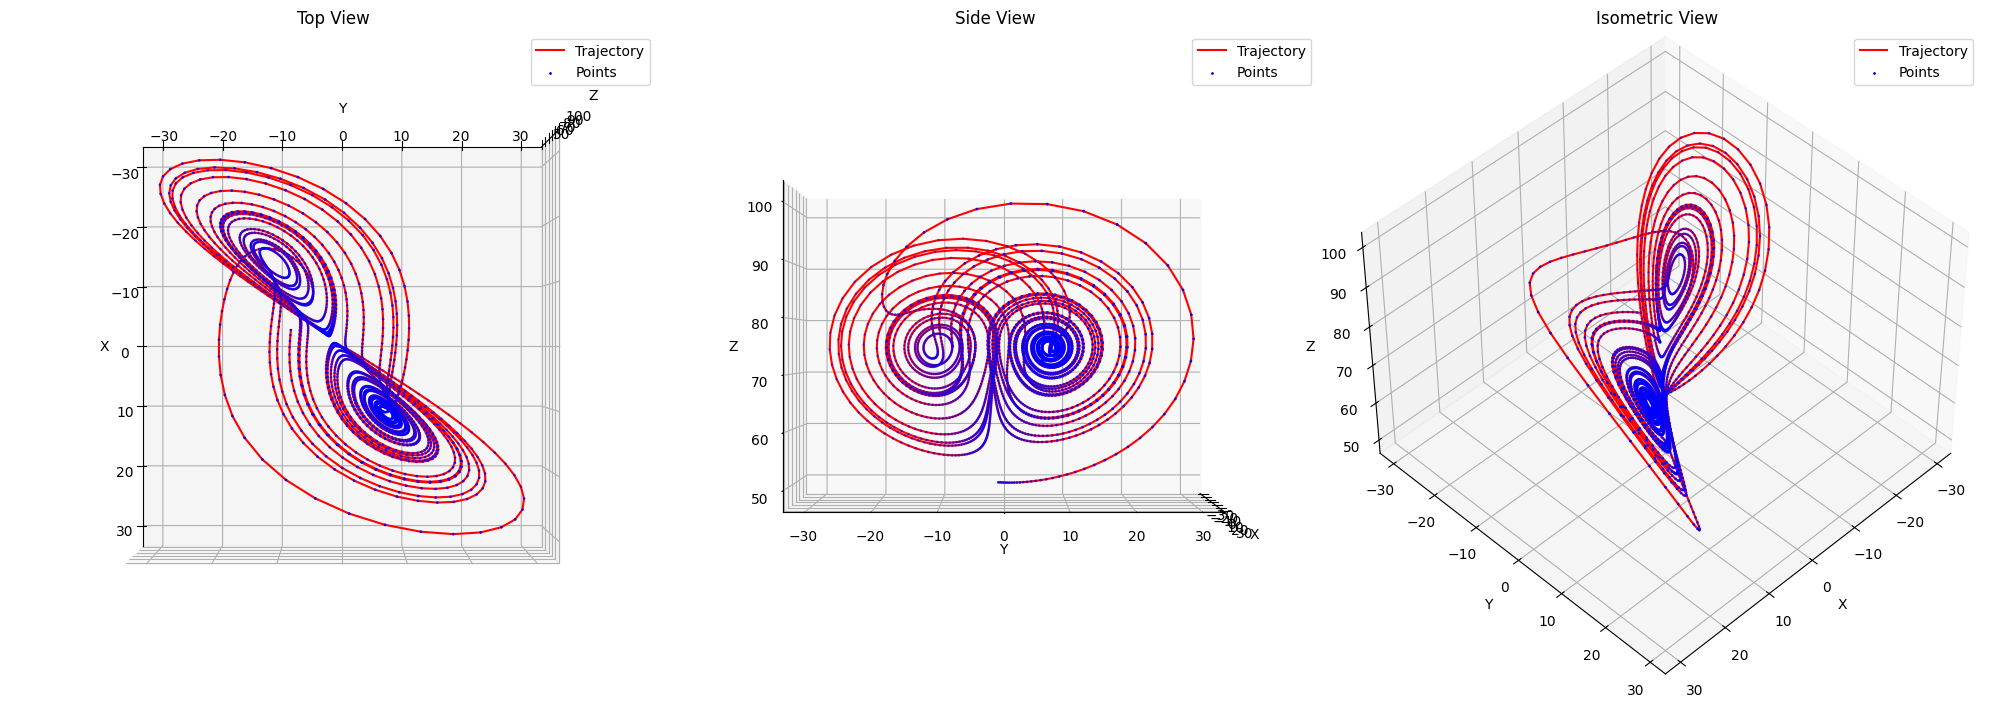

In [3]:
generate_exp_data_3D(
    "Lorenz",           # Trajektorie
    0.3,              # r_path (Radius) 0.7, 0.6, 0.5, 0.4, 0.3, 0.2
    15,               # r_anomaly (Anomalieparameter)
    "Acryl Glas",     # Material
) #3D: 0.7 und 0.3 und 0.5 interpolieren

In [4]:
def create_cylinder_mesh(radius, height, n_points=100):
    theta = np.linspace(0, 2*np.pi, n_points)
    z = np.linspace(0, height, n_points)
    theta, z = np.meshgrid(theta, z)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return x, y, z



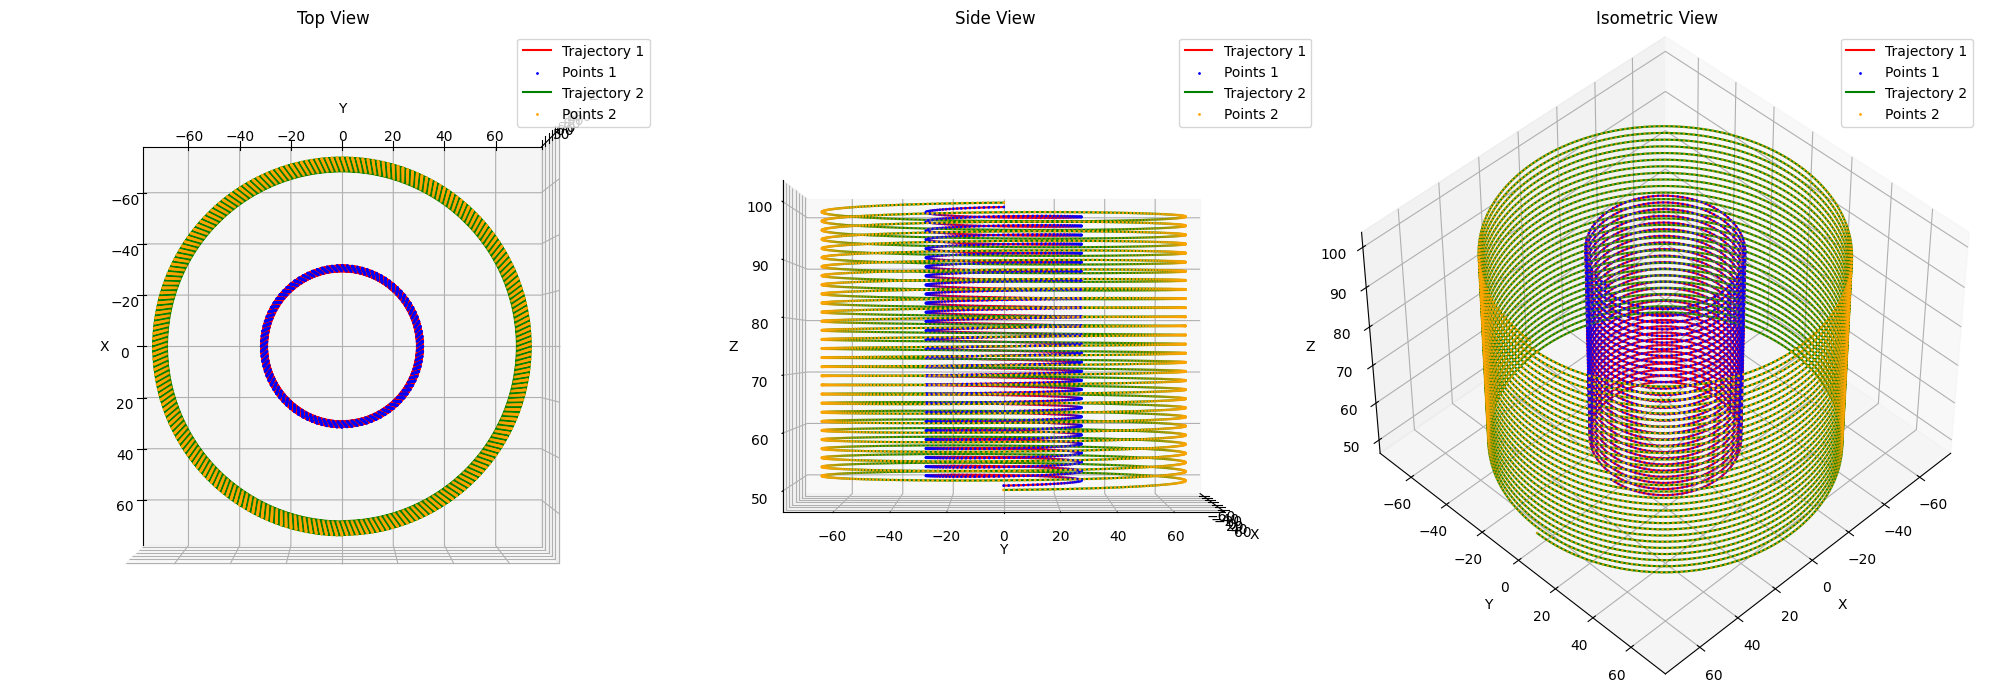

In [5]:
fig = plt.figure(figsize=(20, 8))
    

center_pos_1 = create_trajectory_3D("Helix", 0.3*97, 3000)
center_pos_2 = create_trajectory_3D("Helix", 0.7*97, 6900)

ax1 = fig.add_subplot(131, projection='3d')

ax1.plot(center_pos_1[:,0], center_pos_1[:,1], center_pos_1[:,2], 
         color='red', label='Trajectory 1')
ax1.scatter(center_pos_1[:, 0], center_pos_1[:, 1], center_pos_1[:, 2], 
            color='blue', marker='o', s=1, label='Points 1')
# Plot second helix
ax1.plot(center_pos_2[:,0], center_pos_2[:,1], center_pos_2[:,2], 
         color='green', label='Trajectory 2')
ax1.scatter(center_pos_2[:, 0], center_pos_2[:, 1], center_pos_2[:, 2], 
            color='orange', marker='o', s=1, label='Points 2')
ax1.view_init(elev=90, azim=0)
ax1.set_title('Top View')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')


ax2 = fig.add_subplot(132, projection='3d')

ax2.plot(center_pos_1[:,0], center_pos_1[:,1], center_pos_1[:,2], 
         color='red', label='Trajectory 1')
ax2.scatter(center_pos_1[:, 0], center_pos_1[:, 1], center_pos_1[:, 2], 
            color='blue', marker='o', s=1, label='Points 1')


ax2.plot(center_pos_2[:,0], center_pos_2[:,1], center_pos_2[:,2], 
         color='green', label='Trajectory 2')
ax2.scatter(center_pos_2[:, 0], center_pos_2[:, 1], center_pos_2[:, 2], 
            color='orange', marker='o', s=1, label='Points 2')
ax2.view_init(elev=0, azim=0)
ax2.set_title('Side View')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')

ax3.plot(center_pos_1[:,0], center_pos_1[:,1], center_pos_1[:,2], 
         color='red', label='Trajectory 1')
ax3.scatter(center_pos_1[:, 0], center_pos_1[:, 1], center_pos_1[:, 2], 
            color='blue', marker='o', s=1, label='Points 1')

ax3.plot(center_pos_2[:,0], center_pos_2[:,1], center_pos_2[:,2], 
         color='green', label='Trajectory 2')
ax3.scatter(center_pos_2[:, 0], center_pos_2[:, 1], center_pos_2[:, 2], 
            color='orange', marker='o', s=1, label='Points 2')
ax3.view_init(elev=45, azim=45)
ax3.set_title('Isometric View')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
for ax in [ax1, ax2, ax3]:
    ax.legend()

plt.show()

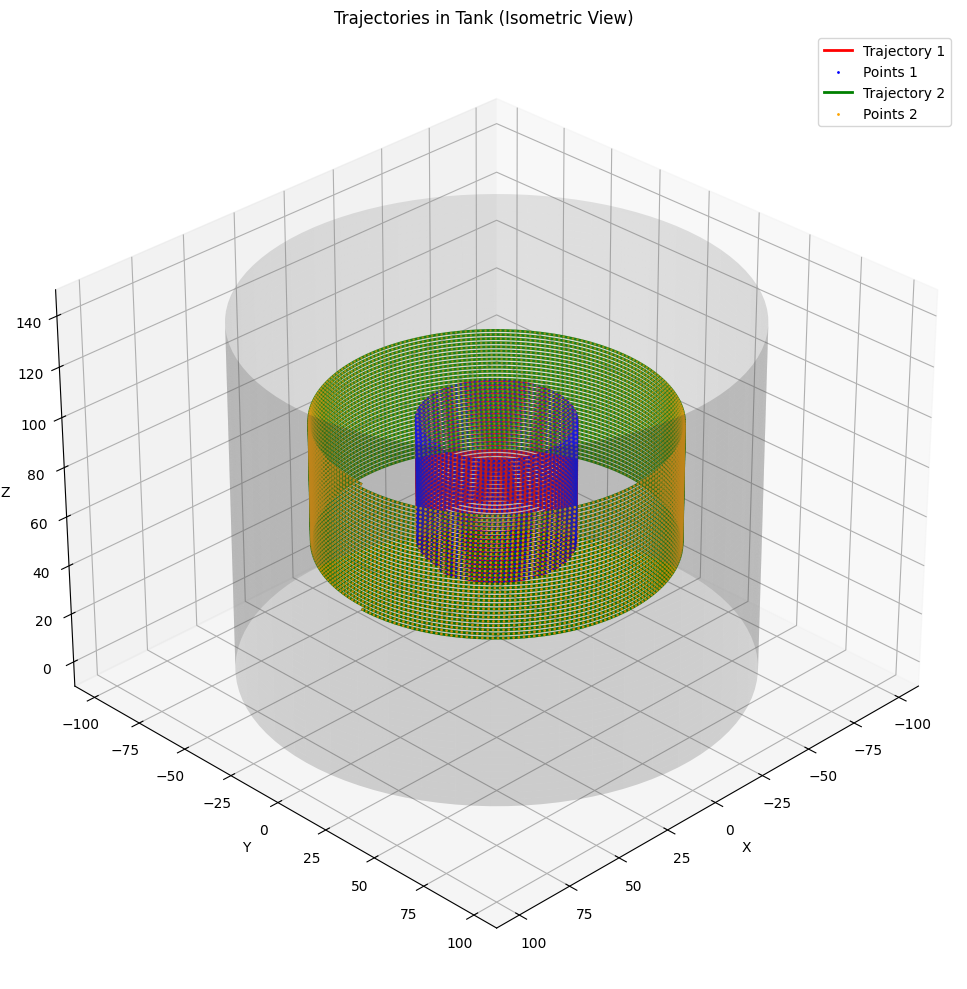

In [6]:
from src.classes import Boundary, TankProperties32x2, BallAnomaly
def plot_trajectories_in_tank(center_pos_1, center_pos_2):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    tank = TankProperties32x2()
    x_cyl, y_cyl, z_cyl = create_cylinder_mesh(tank.T_r, tank.T_bz[1])
    ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.2, color='gray')  
    
    ax.plot(center_pos_1[:,0], center_pos_1[:,1], center_pos_1[:,2], 
            color='red', label='Trajectory 1', linewidth=2)
    ax.scatter(center_pos_1[:, 0], center_pos_1[:, 1], center_pos_1[:, 2], 
               color='blue', marker='o', s=1, label='Points 1')
    
    ax.plot(center_pos_2[:,0], center_pos_2[:,1], center_pos_2[:,2], 
            color='green', label='Trajectory 2', linewidth=2)
    ax.scatter(center_pos_2[:, 0], center_pos_2[:, 1], center_pos_2[:, 2], 
               color='orange', marker='o', s=1, label='Points 2')
    
    ax.view_init(elev=30, azim=45)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trajectories in Tank (Isometric View)')
    
    ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_trajectories_in_tank(center_pos_1, center_pos_2)

In [9]:
center_pos_1 = create_trajectory_3D("Spherical", 0.3*97, 3000)
center_pos_2 = create_trajectory_3D("Spherical", 0.7*97, 6900)

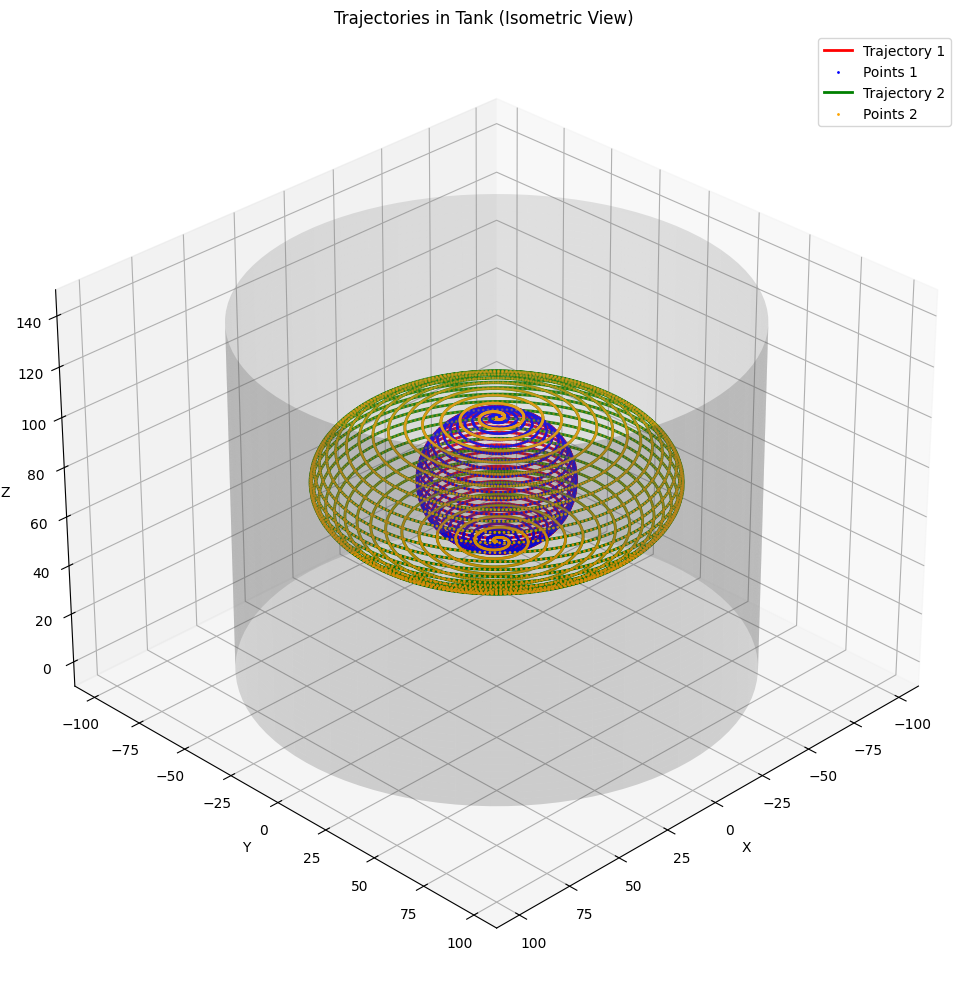

In [10]:
plot_trajectories_in_tank(center_pos_1, center_pos_2)